### First
I began by opening the excel file, noted it had 4 sheets, one of which was data and the rest were related to the challenge itself.

### Second
I chose to complete this in Python as it is becoming my language of choice, I find that employers prefer it to R (which I am generally stronger in), the visualizations are simpler to handle, and I can easily share the Jupyter Notbook with you in a state that demonstrates the outcome of my operations

### Third
I imported libraries to handle the data and began a short EDA (exploratory data analysis) to determine an idea of what I was working with and to approach the questions that I am posed in A and B.

### Fourth
Plan:
    * Observe the frequency distribution of the time periods
    * Find the average number of times a user uses the portal
    * Find the portal page that is most and least frequently viewed
    * Indicate the time periods of use and view the frequency distributions for each page
        * Make a plot for each page's distribution, "hued" by week
        * Check the mean for each period for each page and see if it "shifts"

#### Initial EDA and transformations
* Import data by utilizing Pandas 'read' functionality and select the appropriate sheet of the data
* Conduct a quick view with 'head' (transposed to make it easier to read, this is personal preference)
    * Noted the User_ID is some sort of hash, I prefer to categorize by counting numbers as strings because thy aren't meant to be operated upon (e.g. adding social security numbers doesn't make sense, so looking at them as stringed categories is more appropriate)
    * Data is not dirty, but is fairly uninformative
        * I will need to construct all of the relevant information

## What can you tell me about this data? What is in this data?

## Does Portal Page usage shift week-to-week (relative to when an User first used the service)?

## How would you improve Portal Page engagement of Users (relative how a User uses the service)?

# Findings

## A
* This data is of a longitudinal nature (panel data in econometrics) such that there are n > 1 observations transitioning over time.
* Each observation contains (what appears to be) a hashed (encrypted by some measure) userID, an organization ID that clusters (or groups) the entities, a first use date signifiying the period of initial use of the portal, a use date signifying the period of use for the observation, and a portal page indicating the page used in the observation.


* Data dimension = 134,950 x 5
    * Number of users = n = 2798
    * Number of observations = N = 134,950
* Time period: Days (YY-MM-DD)
    * Number of Time Periods = T = 34
    * First time period = 2015-01-07
    * Last time period = 2015-02-09
    * Day with most uses: 2015-01-13 (8166)
    * Day with least uses: 2015-02-09 (468)
* Number of portal pages: 6
    * Most frequently visited page: Discovery Cube (105489 visits)
    * Least frequently visited page: Bullseye Chart (1183 visits)
    * Most frequently visited page on first use: Discovery Cube (5017 visits)
    * Least frequently visited page on first use: Spider Chart (61 visits)
* Number of groups (Org_ID): 10
    * Most populated group: BLN (695 users)
    * Least populated group: WMT (2 users)
    * Most frequently visits pages: EZ (29318 uses)
    * Least frequently visits pages: WMT (1923 uses)
    

## B
* Yes, portal page usage shifts week-to-week.
    * As the date of first use distinguishes only the day the user first uses the protal, but doesn't distinguish which page is used first, last, or otherwise, then I can't say much about how the average usage of a particular page shifts with time relative to the user's first use of the page unless I make some broad assumptions. Given I have no background on this data, I don't feel comfortable standing behind those assumptions I would place forth - Discovery Cube is the landing page of the data, people go from the landing page generally to the Fingerprint Chart page, etc.

## C
* I have some issues making suggestions based on the lack of information in and about the inital data. To give a more robust response, I would like to know the sequence of the page use. That is, I would like to know which page a user uses first, second, and so forth, to the end of their time with the portal. 
* My initial thought was to check some form of markov process on this, finding what pages transition to others, and suggest filtering people to those different pages that have those strongest "absorbing states". My next thought was to see how long a user remains on a page. But, as I only know all of the pages a user uses in a day, I can only say something about the frequency of those pages - I don't have enough information to confidently state which page is most likely to improve portal engagement.
* With that, knowing only the frequencies, I won't employ the other techniques I'd like (especially PCA), and will address only their correlations.
* The Discovery Cube portal page is the most frequently used, week over week, followed by the Fingerprint Chart and Product Reccomendation. I don't know if that means these are defaut pages the user sees when using the portal, but if they are not, then perhaps users should be directd to use one of these three.
    * We can see the Fingerprint Chart, Bullseye Chart, Mashboard, and Product Recommendation portal pages are highly correlated, so directing through/to those may influence the frequency as which users use either page.
    
# Comments
The level of this data's information doesn't seem robust enough to address the comments completely.

# Working through A

In [1]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
# Importing
df = pd.read_excel('/Users/mbair/Git/ConvexOptimizationWithPython/data/DSx.xlsx', sheet_name = 'Data')
df.head(5)

,User_ID,Org_ID,First_Use_Date,Use_Date,Portal_Page
0,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube
1,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube
2,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube
3,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube
4,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube


In [3]:
# Control for some naive levels of bad data

# Make sure the data only appears where the fi
df = df[df['First_Use_Date'] <= df['Use_Date']]

# Remove rows with null - the data is fairly uninformative in its current state so replacing null values with anything at this point is not going to help with later analysis
df.dropna(axis=0, how='any', inplace=True)

In [4]:
# Find a few specifics of the data
minDate = df['Use_Date'].min()
maxDate = df['Use_Date'].max()
uniqueDate = df['Use_Date'].nunique()
print('The time span is from {} to {} with {} periods.'.format(minDate, maxDate, uniqueDate))
print()
n = df['User_ID'].nunique()
g = df['Org_ID'].nunique()
avgN = df['User_ID'].value_counts().mean()
print('The number of users is {}, appearing approximately {:,.2f} times, grouped under {} organizations.'.format(n, avgN, g))
print()
pPage = df['Portal_Page'].nunique()
print('There are {} unique portal pages titled: {}.'.format(pPage, list(df['Portal_Page'].unique())))
print()
print(df['Portal_Page'].value_counts())
print()
print(df[df['First_Use_Date'] == df['Use_Date']]['Portal_Page'].value_counts())
print()
print(df.groupby('Org_ID')['User_ID'].nunique())
print()
print(df['Org_ID'].value_counts())
print()
print(df['Use_Date'].value_counts())
print()
df.describe().T

The time span is from 2015-01-07 00:00:00 to 2015-02-09 00:00:00 with 34 periods.

The number of users is 2798, appearing approximately 48.23 times, grouped under 10 organizations.

There are 6 unique portal pages titled: ['Discovery Cube', 'Fingerprint Chart', 'Mashboard', 'Spider Chart', 'Bullseye Chart', 'Product Recommendation'].

Discovery Cube            105489
Fingerprint Chart          21802
Product Recommendation      2711
Mashboard                   2339
Spider Chart                1426
Bullseye Chart              1183
Name: Portal_Page, dtype: int64

Discovery Cube            5017
Fingerprint Chart         1370
Product Recommendation     283
Mashboard                  164
Bullseye Chart              78
Spider Chart                61
Name: Portal_Page, dtype: int64

Org_ID
ASP      58
BLN     695
DGO     618
EZ      242
NW      515
ONG      75
P158    378
SBD       7
USS     208
WMT       2
Name: User_ID, dtype: int64

EZ      29318
P158    28914
NW      20316
BLN     15859
A

,count,unique,top,freq,first,last
User_ID,134950,2798,eb43dc75-8c60-487c-9615-4e750042a0e3-26930-7f4...,1096,NaN,NaN
Org_ID,134950,10,EZ,29318,NaN,NaN
First_Use_Date,134950,7,2015-01-07 00:00:00,25134,2015-01-07 00:00:00,2015-01-13 00:00:00
Use_Date,134950,34,2015-01-13 00:00:00,8166,2015-01-07 00:00:00,2015-02-09 00:00:00
Portal_Page,134950,6,Discovery Cube,105489,NaN,NaN


# Working through B

In [5]:
# Add variables for manipulation and for simplicity in viewing

# Use this instead of the hashed User_ID for indexing - just easier for me to view if I need to
df['id'] = pd.Categorical((pd.factorize(df['User_ID'])[0] + 1).astype(str))

df['group'] = df['Org_ID'].astype('category').cat.rename_categories(range(1, df['Org_ID'].nunique() + 1))
df['period'] = df['Use_Date'].astype('category').cat.rename_categories(range(1, df['Use_Date'].nunique() + 1))
df['week'] = df['Use_Date'].dt.week
df['page'] = pd.Categorical((pd.factorize(df['Portal_Page'])[0] + 1).astype(str))

df.head(5)

,User_ID,Org_ID,First_Use_Date,Use_Date,Portal_Page,id,group,period,week,page
0,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1
1,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1
2,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1
3,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1
4,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1


In [6]:
# Create variables for values

# Total times each unique user appears in the data set
df['totalPageUsesOverall'] = df.groupby('Portal_Page')['Portal_Page'].transform('count')
df['totalPortalUsesByUser'] = df.groupby('User_ID')['User_ID'].transform('count')
df['totalPortalByUserByWeek'] = df.groupby(['User_ID', 'week'])['User_ID'].transform('count')
df['totalPageUsesByUser'] = df.groupby(['User_ID', 'Portal_Page'])['Portal_Page'].transform('count')
df['totalPageByUserByWeek'] = df.groupby(['User_ID', 'week', 'Portal_Page'])['Portal_Page'].transform('count')
df['totalPageUsesByUserByDay'] = df.groupby(['User_ID', 'Use_Date', 'Portal_Page'])['Portal_Page'].transform('count')

df.head()

,User_ID,Org_ID,First_Use_Date,Use_Date,Portal_Page,id,group,period,week,page,totalPageUsesOverall,totalPortalUsesByUser,totalPortalByUserByWeek,totalPageUsesByUser,totalPageByUserByWeek,totalPageUsesByUserByDay
0,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,105489,61,25,55,25,11
1,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,105489,61,25,55,25,11
2,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,105489,61,25,55,25,11
3,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,105489,61,25,55,25,11
4,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,105489,61,25,55,25,11


In [7]:
# Total number of days each unique user appears in the data set
numDays = pd.DataFrame(df.groupby('User_ID')['Use_Date'].nunique())
numDays.columns = ['numDaysByUser']
df = pd.merge(df, numDays, how = 'inner', on = 'User_ID')

# Total number of weeks each unique user appears in the data set
numWeeks = pd.DataFrame(df.groupby('User_ID')['week'].nunique())
numWeeks.columns = ['numWeeksByUser']
df = pd.merge(df, numWeeks, how = 'inner', on = 'User_ID')

df.head()

,User_ID,Org_ID,First_Use_Date,Use_Date,Portal_Page,id,group,period,week,page,totalPageUsesOverall,totalPortalUsesByUser,totalPortalByUserByWeek,totalPageUsesByUser,totalPageByUserByWeek,totalPageUsesByUserByDay,numDaysByUser,numWeeksByUser
0,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,105489,61,25,55,25,11,16,4
1,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,105489,61,25,55,25,11,16,4
2,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,105489,61,25,55,25,11,16,4
3,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,105489,61,25,55,25,11,16,4
4,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,105489,61,25,55,25,11,16,4


In [8]:
# Relevant Averages

# Average daily portal usage for each unique user
df['avgPortalUsesByUser'] = df['totalPortalUsesByUser'] / df['numDaysByUser']
# Average weekly portal usage for each unique user
df['avgPortalUsesByUserByWeek'] = df['totalPortalByUserByWeek'] / df['numWeeksByUser']

# Average page usage for each unique user
df['avgPageOverall'] = df['totalPageUsesByUser'] / df['numDaysByUser']

# Average weekly page usage for each unique user
df['avgPageWeekly'] = df['totalPageByUserByWeek'] / df['numWeeksByUser']

# Like to find the average number of times a protal page is used on average by week given the total number of times users access a particular page ina aparticular week
df.head()

,User_ID,Org_ID,First_Use_Date,Use_Date,Portal_Page,id,group,period,week,page,...,totalPortalByUserByWeek,totalPageUsesByUser,totalPageByUserByWeek,totalPageUsesByUserByDay,numDaysByUser,numWeeksByUser,avgPortalUsesByUser,avgPortalUsesByUserByWeek,avgPageOverall,avgPageWeekly
0,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,...,25,55,25,11,16,4,3.8125,6.25,3.4375,6.25
1,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,...,25,55,25,11,16,4,3.8125,6.25,3.4375,6.25
2,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,...,25,55,25,11,16,4,3.8125,6.25,3.4375,6.25
3,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,...,25,55,25,11,16,4,3.8125,6.25,3.4375,6.25
4,07e1e890-947a-42a5-bff6-a6905f6dc2cf-1046-10b2...,P158,2015-01-12,2015-01-12,Discovery Cube,1,7,6,3,1,...,25,55,25,11,16,4,3.8125,6.25,3.4375,6.25


In [9]:
df1 = df.pivot_table(values = 'totalPageByUserByWeek', index = 'week', columns = 'Portal_Page')
df1.head(6)

Portal_Page,Bullseye Chart,Discovery Cube,Fingerprint Chart,Mashboard,Product Recommendation,Spider Chart
week,,,,,,
2,3.352941,29.339684,13.323896,7.748491,7.650718,4.122302
3,4.432990,44.128553,15.439156,7.037736,8.293303,5.338658
4,4.678571,45.202397,12.114363,9.969977,17.354049,2.105000
5,2.671958,40.622429,10.969443,4.827381,5.994318,2.808824
6,3.857143,30.234046,12.022621,5.725552,11.160991,2.337580
7,1.000000,9.568966,3.578313,2.428571,2.666667,1.888889


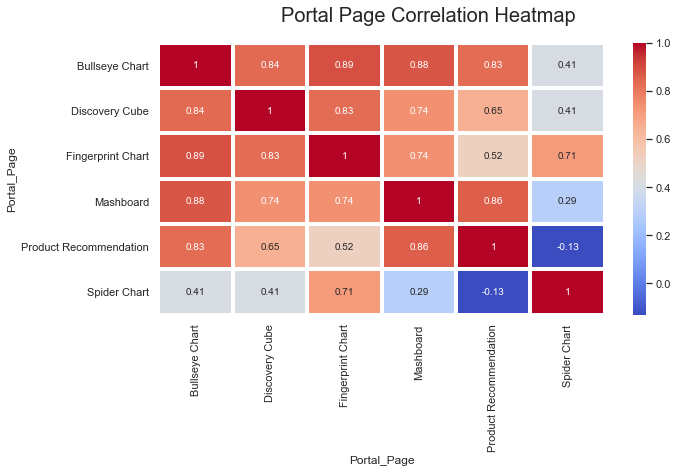

In [10]:
# See correlations of pages
f, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(round(df1.corr(),2), cmap = 'coolwarm', linecolor = 'white', annot = True, linewidths = 3)
t = f.suptitle('Portal Page Correlation Heatmap', fontsize=20)

* Bullseye and Fingerprint Chart are highly correlated (0.89)
* Discovery Cube and Bullseye Chart are highly correlated (0.84)
* Mashboard and Bullseye Chart are highly correlated (0.88)
* Product Recommendation and Mashboard are highly correlated (0.86)
* Spider and Fingerprint Chart are highly correlated (0.71)
* Spider Chart and Product Recommendation are negatively correlated (-0.13)

Text(0.5, 0.98, 'Portal Page Average Usage By Week')

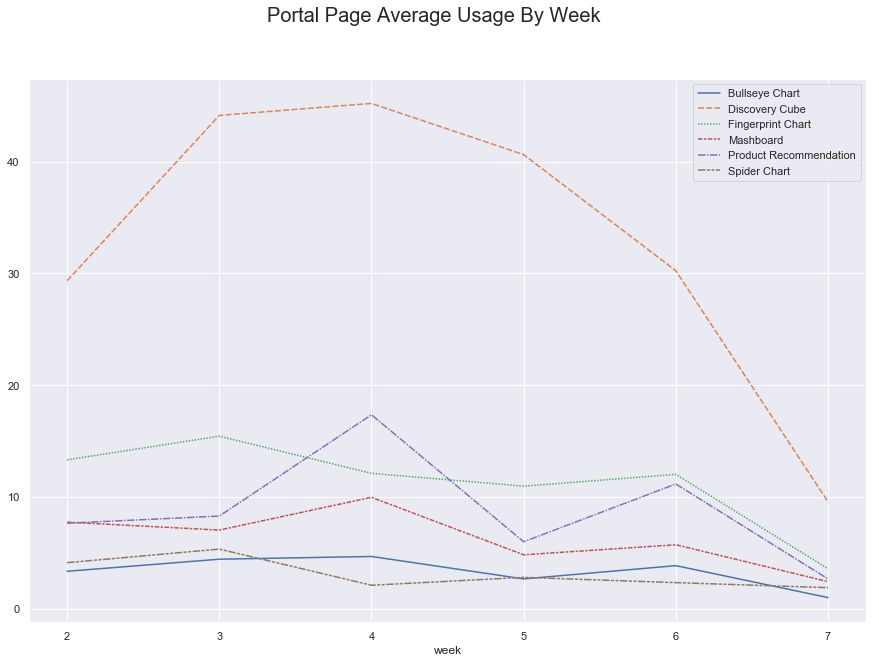

In [11]:
f, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(data=df1)
f.suptitle('Portal Page Average Usage By Week', fontsize=20)

/Users/mbair/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0.98, 'Distribution of Average Page Usage by Users Over Weeks')

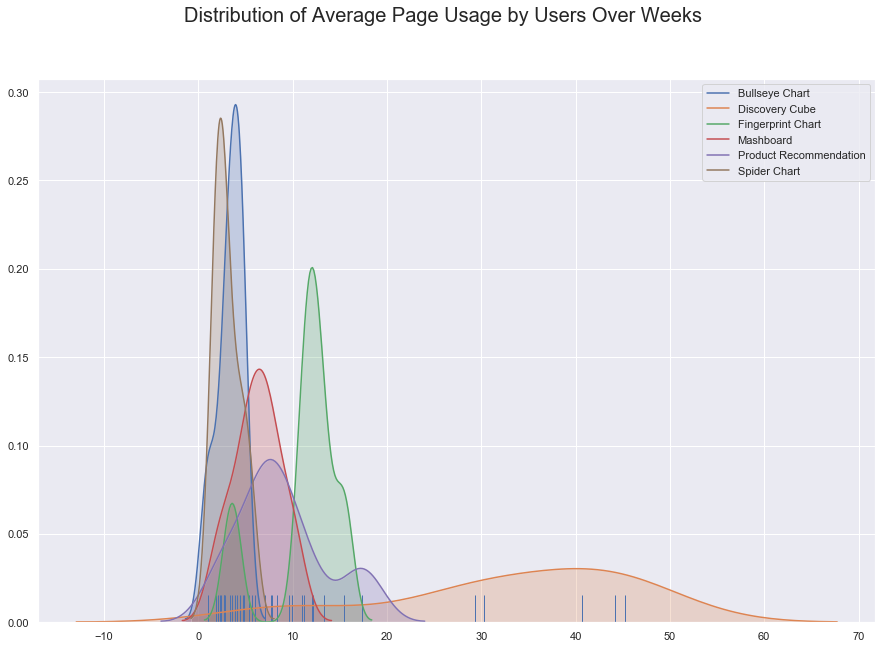

In [12]:
f, ax = plt.subplots(figsize=(15, 10))
for page in list(df1.columns):
    sns.kdeplot(df1[page], shade = True)
    sns.rugplot(df1[page])
f.suptitle('Distribution of Average Page Usage by Users Over Weeks', fontsize = 20)

# Working through C

Text(0.5, 0.98, 'Portal Page Correlation Heatmap')

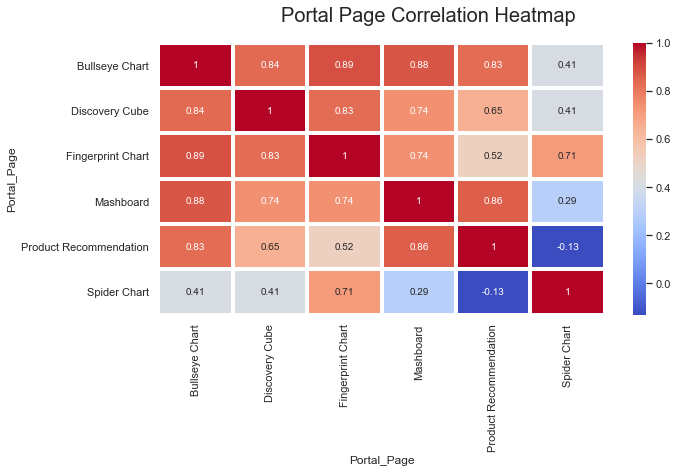

In [13]:
# See correlations of pages
f, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(round(df1.corr(),2), cmap = 'coolwarm', linecolor = 'white', annot = True, linewidths = 3)
f.suptitle('Portal Page Correlation Heatmap', fontsize=20)

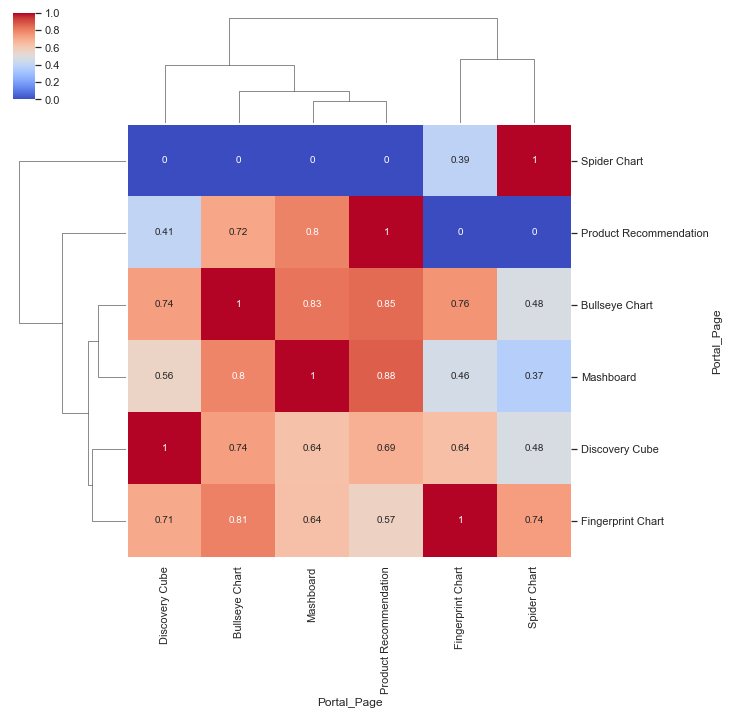

In [14]:
sns.clustermap(df1.corr(), cmap = 'coolwarm', annot = True, standard_scale = 1)